# Assignment 6: Bagging and Boosting

# Yanling Wu (yw996)

In this assignment, we are going to revisit the chess(King-Rook vs. King) Endgame Classification problem we saw in the first assignment. Recall that using decision trees, we couldn't get good testing accuracy (around 55%).  We will try to improve this using ensemble methods.

## Chess(King-Rook vs. King) Endgame Classification
For introduction and rules of Chess, see [Wiki page](https://en.wikipedia.org/wiki/Chess). 

<img src="chess.png" width="400">

We will use Chess(King-Rook vs. King) Data Set from UCI machine learning repository. (See introduction [here](https://archive.ics.uci.edu/ml/datasets/Chess+(King-Rook+vs.+King)). This database has 28056 possible instances of chess endgame situations where the white has a king and a rook and the black has only a king. The goal is to determine what is the minimum depth for the white to win.

The dataset has 6 attributes. Each of them can take 8 values, listed as following:

1. White King file (column a - h) 
2. White King rank (row 1 - 8) 
3. White Rook file 
4. White Rook rank 
5. Black King file 
6. Black King rank 

And the label/class is the least number of steps that white must use to win. (draw if more than 16). The following is how the data set looks like.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle
chess = pd.read_csv('./krkopt_data.txt', header=None)
chess.columns = ['wkf', 'wkr', 'wrf', 'wrr', 'bkf', 'bkr', 'class']
chess = shuffle(chess, random_state = 0)
chess.head(10)

,wkf,wkr,wrf,wrr,bkf,bkr,class
22363,b,2,d,1,g,7,fourteen
18474,c,2,a,6,e,6,thirteen
24609,d,1,d,2,f,4,fourteen
3668,d,2,h,1,a,2,five
6969,c,1,f,5,g,1,nine
4007,d,1,b,4,h,1,six
16585,d,3,h,1,c,6,twelve
5441,c,2,b,4,g,1,eight
6712,b,1,e,3,g,1,nine
27543,d,1,f,4,e,6,fifteen


Next we convert these values into boolean features using the same one-hot encoding trick we described for TIC-TAC-TOE game. Deleting symmetric features for the white king and drop the first for the others, we get a data set with $36$ boolean features. 

Next we randomly pick $70\%$ of the data to  be our training set and the remaining for testing. Training set looks like the following:

In [8]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
d_wkf = pd.get_dummies(chess['wkf'], prefix='wkf')
d_wkr = pd.get_dummies(chess['wkr'], prefix='wkr')
d_wrf = pd.get_dummies(chess['wrf'], prefix='wrf', drop_first=True)
d_wrr = pd.get_dummies(chess['wrr'], prefix='wrr', drop_first=True)
d_bkf = pd.get_dummies(chess['bkf'], prefix='bkf', drop_first=True)
d_bkr = pd.get_dummies(chess['bkr'], prefix='bkr', drop_first=True)
chess_new = pd.concat([d_wkf, d_wkr, d_wrf, d_wrr, d_bkf, d_bkr, chess['class']], axis=1)
X = chess_new.iloc[:, :-1]
y = chess_new['class']
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.head(10)

,wkf_a,wkf_b,wkf_c,wkf_d,wkr_1,wkr_2,wkr_3,wkr_4,wrf_b,wrf_c,...,bkf_f,bkf_g,bkf_h,bkr_2,bkr_3,bkr_4,bkr_5,bkr_6,bkr_7,bkr_8
3409,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18073,0,0,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3544,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8869,0,0,1,0,0,1,0,0,1,0,...,0,1,0,0,1,0,0,0,0,0
11300,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
10037,0,0,0,1,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
18156,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
17803,0,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
13751,0,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
3240,0,0,0,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


## 1. Bagging and Random Forest.
Recall that the classifier we get by bagging with decision trees as our base classifier is called Random Forest. Using the Bagging Meta Classifier implemented in 'sklearn.ensemble'. See [Scikit Learn Bagging](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html#sklearn.ensemble.BaggingClassifier) for how to use it. (Don't use the random forest classifier in 'sklearn.ensemble' directly since it has other parameters and you may get weird results). Using information gain as your splitting criterion and train a random forest with number of classifiers in the following set:

$$n = \{ 2^i | i = 0, 1, ..., 11\}$$

Plot the training and testing accruracy and justify your plot.

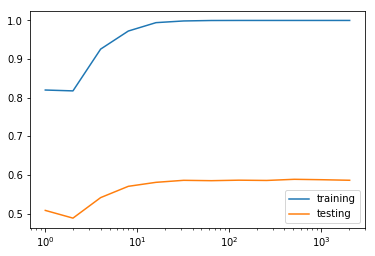

In [9]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
n_max = 12
Err_Train = np.zeros(n_max)
Err_Test = np.zeros(n_max)
indices = 2**np.array(range(0,n_max))
#==========Write your code below=====
for i in range(0, n_max):
    clf = BaggingClassifier(base_estimator = DecisionTreeClassifier(criterion = "entropy"), 
                             n_estimators  = indices[i])
    model = clf.fit(X_train, y_train)
    y_pre_test = clf.predict(X_test)
    y_pre_train = clf.predict(X_train)
    Err_Train[i] = accuracy_score(y_pre_train, y_train)
    Err_Test[i] = accuracy_score(y_pre_test, y_test)

#================================

plt.semilogx(indices,Err_Train, label = "training")
plt.semilogx(indices,Err_Test, label = "testing")
plt.legend()

## Explanation: 
- As we can see, the general trend of change is that the training accuracy increases as the number of base estimators in the ensemble increasing until the training accuracy increases to 1. And the accuracy of the testing data also increases from some point and stay the stable later when the training accuracy becomes 1. 
- We know the bagging could help to reduce the effect of the overfitting by reducing the variance. That is why we could see the testing arruracy could increase a little bit. But it only could help to recude the effect of overfitting, not eliminating it, so when the training accuracy is up to 1, the rnadom forest model still overfitting, and the accuracy of the testing stop increasing. 
- As for the decrease of testing accuracy at first, I think it could be coused by the small number of bagging since the effect of reducing the overfitting is very limited when the number of the bagging is small. 

## 2. Adaboost.

Decision trees with small maximum depth won't give us good performance because of limited complexity. In this problem, we use adaboost algorithm to reduce the bias of the model and hopefully this will give us better performance. Using decision trees with maximum depth 10, 20, 50, 100 as you base classifiers, try [Adaboost algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier) with number of iterations in the following set:

$$T = \{ 2^i | i = 0, 1, ..., 11\}$$

Plot your training and testing error and justify your plots. When do you get zero training error? Explain.

Text(0.5,1,'max_depth = 100')

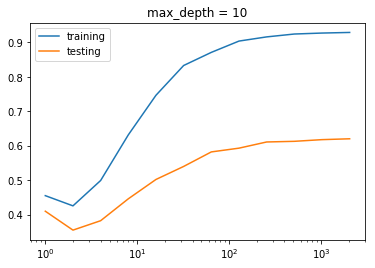

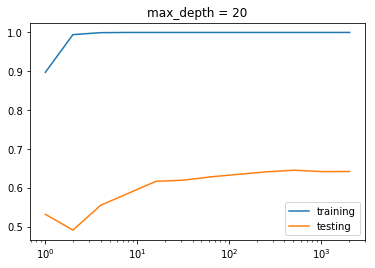

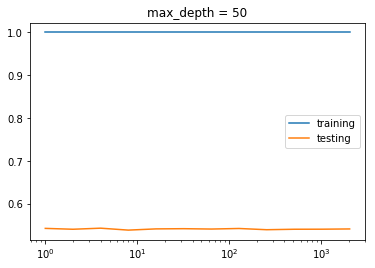

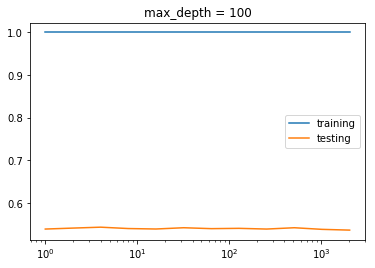

In [25]:
from sklearn.ensemble import AdaBoostClassifier
n_max = 12
Err_Train = np.zeros(n_max)
Err_Test = np.zeros(n_max)
indices = 2**np.array(range(0,n_max))
#==========Write your code below=====
#You can repeat this block multiple times for your experiments.
for i in range(0, n_max):
    clf = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(criterion = "entropy", max_depth = 10), 
                             n_estimators  = indices[i])
    model = clf.fit(X_train, y_train)
    y_pre_test = clf.predict(X_test)
    y_pre_train = clf.predict(X_train)
    Err_Train[i] = accuracy_score(y_pre_train, y_train)
    Err_Test[i] = accuracy_score(y_pre_test, y_test)

#================================
plt.figure()

plt.semilogx(indices,Err_Train, label = "training")
plt.semilogx(indices,Err_Test, label = "testing")
plt.legend()
plt.title("max_depth = 10")

for i in range(0, n_max):
    clf = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(criterion = "entropy", max_depth = 20), 
                             n_estimators  = indices[i])
    model = clf.fit(X_train, y_train)
    y_pre_test = clf.predict(X_test)
    y_pre_train = clf.predict(X_train)
    Err_Train[i] = accuracy_score(y_pre_train, y_train)
    Err_Test[i] = accuracy_score(y_pre_test, y_test)

#================================
plt.figure()
plt.semilogx(indices,Err_Train, label = "training")
plt.semilogx(indices,Err_Test, label = "testing")
plt.legend()
plt.title("max_depth = 20")

for i in range(0, n_max):
    clf = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(criterion = "entropy", max_depth = 50), 
                             n_estimators  = indices[i])
    model = clf.fit(X_train, y_train)
    y_pre_test = clf.predict(X_test)
    y_pre_train = clf.predict(X_train)
    Err_Train[i] = accuracy_score(y_pre_train, y_train)
    Err_Test[i] = accuracy_score(y_pre_test, y_test)

#================================
plt.figure()
plt.semilogx(indices,Err_Train, label = "training")
plt.semilogx(indices,Err_Test, label = "testing")
plt.legend()
plt.title("max_depth = 50")

for i in range(0, n_max):
    clf = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(criterion = "entropy", max_depth = 100), 
                             n_estimators  = indices[i])
    model = clf.fit(X_train, y_train)
    y_pre_test = clf.predict(X_test)
    y_pre_train = clf.predict(X_train)
    Err_Train[i] = accuracy_score(y_pre_train, y_train)
    Err_Test[i] = accuracy_score(y_pre_test, y_test)

#================================
plt.figure()
plt.semilogx(indices,Err_Train, label = "training")
plt.semilogx(indices,Err_Test, label = "testing")
plt.legend()
plt.title("max_depth = 100")

## Explanation
- We could see that when the maximum depth of the tree is bigger, it will be eaier to overfit. And When the max_depth is 50 and 100, it will overfit at first and the training accuracies are 1 at first, and also it seems that the adaboost has little influence on imporving the performance of prediction. This is because the max_depth is too big so that the every estimator model have learned all the information of training data including noise, so the adamboost has little influence on improing the performance. 
- When max_depth is 10, the adamboost can improve the performance of this model and increase the tesing accuracy because the adamboost could decrease the bias of the model to reduce the effect of the overfitting. Perhaps, on account of small the max_depth 10, the accuracy of the training data set did not go to 1 for this model. 
- When max_depth is 20 and the testing accuracy reached to the lowest, the training accracy is up to 1. Then, the testing accuracy starts to increase and the training accuracy stays 1. This might because when the number of the estimators is small, the effect of reducing overfitting is limited, so the overfitting still happens, and thus the training accuracy keeps increasing and the testing accuracy keeps decreasing. When the number of the estimator increaseing, the effect of reducing overfitting also increases and the testing accuracy increases. 


## 3. Boosting Complex Classifiers.

Using random forest with 10 trees and max_depth 50 as your base classifier, train an AdaBoost classifier with number 
of iterations from 

$$T = \{ 2^i | i = 0, 1, ..., 6\}$$

Plot the training and testing error. Justify your plot.

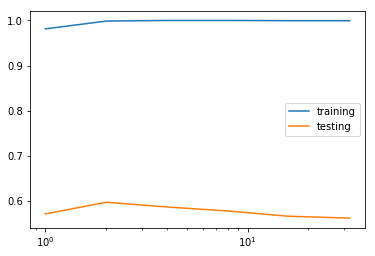

In [21]:
from sklearn.ensemble import AdaBoostClassifier
n_max = 6
Err_Train = np.zeros(n_max)
Err_Test = np.zeros(n_max)
indices = 2**np.array(range(0,n_max))
#==========Write your code below=====
for i in range(0, n_max):
    clf = AdaBoostClassifier(base_estimator = BaggingClassifier(base_estimator = DecisionTreeClassifier(criterion = "entropy",max_depth = 50), n_estimators  = 10),
                             n_estimators  = indices[i])
    model = clf.fit(X_train, y_train)
    y_pre_test = clf.predict(X_test)
    y_pre_train = clf.predict(X_train)
    Err_Train[i] = accuracy_score(y_pre_train, y_train)
    Err_Test[i] = accuracy_score(y_pre_test, y_test)

#================================
plt.semilogx(indices,Err_Train, label = "training")
plt.semilogx(indices,Err_Test, label = "testing")
plt.legend()

## Explanation
- Compared with the last problem, the figure with max_depth 50 and without bagging, this testing accuracy has been improved at first and then the testing accuracy goes down. Using the bagging to decrease the bias and the adamboost to decrease the variance at the same time could decrease the overfitting, and thus, the testing accuracy increases. 
- I noticed one thing that the first accuracy of the training dataset is less than 1 but in the last problem only with adaboost and no bagging, the accuacty of the first accuracy is 1 because when using bagging, randomly choose the data from the training dataset, it is possible to choose the dataset that can lead to the result that the the first accuracy is less than 1. 
- Also, when the accuracy of training dataset is not equal to 1, it means there are some wrong prediction data, and the adaboost could be used to work so at first, the testing accuracy increase. However, when the training accuracy is up to 1, there is no wrong prediction data, which means the adaboost will not work because there is no wrong data for it to change the weight. After the accuracy of the training dataset becomes 1, there will accumulate more overfitting models to predict where the training accuracy is 1 but the testing accuracy will decrease. 
